In [1]:
"""Continuous one class svm."""

%matplotlib inline

import numpy as np
import functools

from bokeh.plotting import figure
from bokeh.models import Slider, CustomJS, ColumnDataSource
from bokeh.io import output_file, show, vform

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
from scipy.optimize import minimize_scalar, brentq, fminbound
from sklearn.kernel_approximation import RBFSampler, SkewedChi2Sampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython.display import display, Math, Latex

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from ipywidgets import interact, FloatSlider, RadioButtons

In [20]:
class OCCSVM:

    def __init__(self, gamma=None, skewness=None, nu=0., step=None, T=1000, D1=1000, D2=100, s=100, delta=1e-3, stop_criterion=1e-6, disp=False):
        self.gamma = gamma
        self.skewness = skewness
        self.step = step
        self.T = T
        self.D1 = D1
        self.D2 = D2
        self.s = s
        self.nu = nu
        self.delta = delta
        self.stop_criterion = stop_criterion
        self.disp = disp
        
    @functools.lru_cache(maxsize=None)
    def _inverse(self, f, delta=1e-5):
        def f_1(y):
            return brentq(lambda x: (f(x) - f(1)) / (f(0) - f(1)) - (1 - y), 0, 1, rtol=delta)
        return f_1

    @staticmethod
    def _predict(phiX, theta, B):
        return np.dot(np.dot(phiX, theta), B)
    
    @staticmethod
    def _tau(phiX, theta):
        return np.dot(phiX, theta)
    
    def _f(self, Xt, nu):
        return self._predict(self.phi1.transform(self.scal.transform(Xt)), self._theta1, self.phi2.transform(self.nu_scal.transform(np.array(nu, ndmin=2, dtype=np.float))).T)
    
    @functools.lru_cache(maxsize=None)
    def _r(self, nu):
        return np.dot(self.phi3.transform(self.nu_scal.transform(np.array(nu, ndmin=2, dtype=np.float))), self._theta2)
    
    @functools.lru_cache(maxsize=None)
    def _g(self, nu):
        return np.mean(self._f(self.X_, nu) - self._r(nu) >= 0)
    
    @functools.lru_cache(maxsize=None)
    def _g1(self, nu):
        return self._inverse(self._g, self.delta)(nu)
    
    @staticmethod
    def problem():
        display(Math(r'f^* = \text{agmin}_{f,\tau}\frac{1}{N}\displaystyle\sum_{i=1}^N\int_{[0,1]}\max(0, \tau(\nu) - f(x_i, \nu))d\nu + \int_{[0,1]}\frac{\nu||f(\cdot, \nu)||^2}{2}d\nu - \int_{[0,1]}\nu\tau(\nu)d\nu'))
    
    def _cost(self, phiX1, phiX3, B, theta1, theta2, nu):
        pred = self._predict(phiX1, theta1, B.T)
        tau = self._tau(phiX3, theta2)
        loss = np.mean(np.mean((pred < tau) * (tau - pred), axis=0))
        reg = np.mean(np.linalg.norm(nu * np.dot(theta1, B.T), axis=0) ** 2) / 2
        margin = np.mean(tau * nu)
        return loss + reg - margin
    
    def fit(self, X):
        self._inverse.cache_clear()
        self._r.cache_clear()
        self._g.cache_clear()
        self._g1.cache_clear()
        
        if self.step is None:
            self.step_ = 1. / self.s
        else:
            self.step_ = self.step
        
        self.X_ = X
        
        # INITIALISATION
        self.scal = StandardScaler()
        Xs = self.scal.fit_transform(self.X_)
        
        nu = np.linspace(0, 0.3, self.s)
        self.nu_scal = MinMaxScaler((0, 1))
        self.nu_scal.fit(nu.reshape(-1, 1))
        if self.skewness is None:
            self.skewness_ = 1 / self.s
        else:
            self.skewness_ = self.skewness
        
        self.phi1 = RBFSampler(gamma=self.gamma, n_components=self.D1, random_state=0)
        self.phi2 = SkewedChi2Sampler(skewedness=self.skewness_, n_components=self.D2, random_state=1)
        self.phi3 = SkewedChi2Sampler(skewedness=self.skewness_, n_components=self.D2, random_state=2)
        
        phiX1 = self.phi1.fit_transform(Xs)
        B = self.phi2.fit_transform(self.nu_scal.transform(nu.reshape(-1, 1)))
        phiX3 = self.phi3.fit_transform(self.nu_scal.transform(nu.reshape(-1, 1)))

        self._theta1 = np.zeros((self.D1, self.D2))
        self._theta2 = np.zeros(self.D2)

        # GRADIENT LEARNING
        t, diff_1, diff_2 = 0, np.inf, np.inf
        criterion = np.inf
        new_cost = np.inf
        
        while criterion > self.stop_criterion:
            pred = self._predict(phiX1, self._theta1, B.T)
            tau = self._tau(phiX3, self._theta2)

            res = (pred < tau).astype(np.float)
            grad_loss_f = np.dot(np.dot(phiX1.T, -res), B) / X.shape[0]
            grad_reg = np.dot(nu * np.dot(self._theta1, B.T), B)
            grad_loss_tau = np.mean(np.dot(res - nu, phiX3), axis=0).ravel()
            
            eta = self.step_ * (1 + .5 * self.step_ * t) ** -1
            self._theta1= self._theta1 - eta * (grad_loss_f + grad_reg)
            self._theta2 = self._theta2 - eta * grad_loss_tau

            if (t % 100 == 0):
                old_cost = new_cost
                new_cost = self._cost(phiX1, phiX3, B, self._theta1, self._theta2, nu)
                criterion = np.abs(old_cost - new_cost)
                if self.disp:
                    gradient_norm = np.sqrt(np.linalg.norm(grad_loss_f + grad_reg) ** 2 + np.linalg.norm(grad_loss_tau))
                    print(eta, gradient_norm, new_cost, criterion)
            t = t + 1
    
    def decision_function(self, Xt, split=None):
        if split is None:
            split = self.nu
        nu = self._g1(split)
        return (self._f(Xt, nu) - self._r(nu)).ravel()
    
    def predict(self, Xt, split=None):
        if split is None:
            split = self.nu
        return np.sign(self.decision_function(Xt, split))


In [12]:
OCCSVM().problem()

<IPython.core.display.Math object>

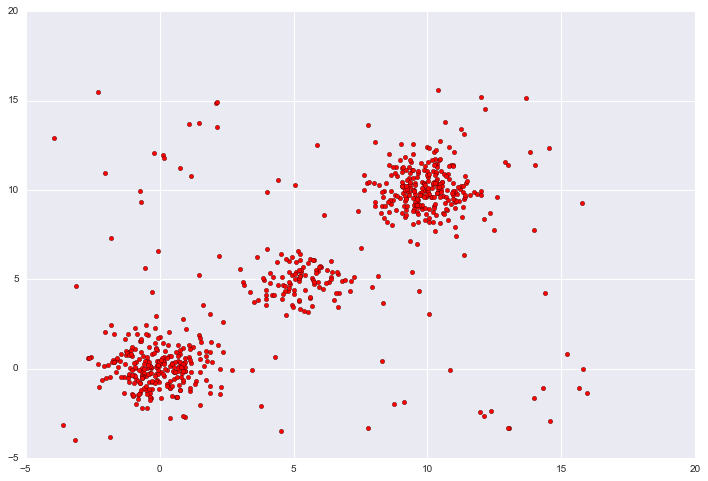

In [14]:
n1 = 250
n2 = 250
n3 = 100
np.random.seed(0)
Xi = np.concatenate((np.random.randn(n1, 2),
                     10 + np.random.randn(n2, 2),
                     np.array([5, 5]) + np.random.randn(n3, 2)))
Xo = 20 * (np.random.rand(100, 2) -.2)
X = np.concatenate((Xi, Xo))
# X = Xi
y = np.empty(X.shape[0])
y[:Xi.shape[0]] = 1
y[Xi.shape[0]:] = 0

estimator = OCCSVM(gamma=2., skewness=1e-3)
estimator.fit(Xi)

Xt = np.empty((10000, 2))
# Xt[:, 0] = np.random.uniform(-5, 15, 10000)
# Xt[:, 1] = np.random.uniform(-5, 15, 10000)
Xt = X

nu_slider = FloatSlider(min=.0, max=1.0, step=.01, value=0.12)
# decorate the plot function with an environment from the UIs:
@interact(nu=nu_slider)
def plot(nu):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 1, 1)

#     ax.grid(color='w', linewidth=2, linestyle='solid')
    x = np.linspace(0, 10, 1000)
    plt.scatter(Xt[estimator.decision_function(Xt, nu) < 0, 0], 
                Xt[estimator.decision_function(Xt, nu) < 0, 1], c='r')
    plt.scatter(Xt[estimator.decision_function(Xt, nu) >= 0, 0], 
                Xt[estimator.decision_function(Xt, nu) >= 0, 1], c='b')
#     ax.set_xlim(-5, 15)
#     ax.set_ylim(-5, 15)

In [ ]:
n1 = 1000
n2 = 1000

Xi = np.concatenate((np.random.randn(n1, 2),
                     10 + np.random.randn(n2, 2),
                     np.array([5, 5]) + np.random.randn(n3, 2)))
Xo = 20 * (np.random.rand(100, 2) -.2)
Xt = np.concatenate((Xi, Xo))

y_test = np.concatenate((np.ones(Xi.shape[0]), -np.ones(Xo.shape[0])))

0.950513847181
0.964702798036
0.965397302064
0.965988369322
0.966105152772
0.966656656657
0.966877353544
0.967097097097
0.967065637066
0.966619953287


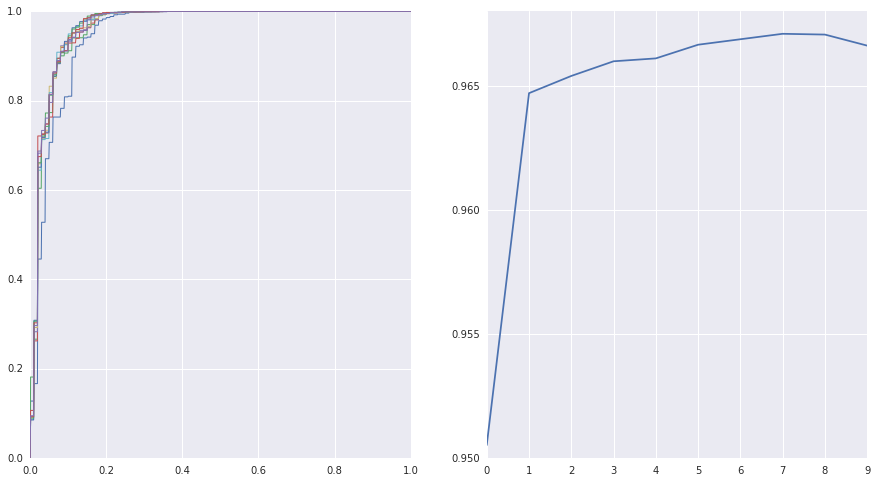

In [94]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

dat = 'Synthetic'
n_axis = 1000
x_axis = np.linspace(0, 1, n_axis)

plt.figure(figsize=(15, 8))
AUC = np.empty(10)
for idx, nu in enumerate(np.linspace(0, 1, 10)):
    scoring = estimator.decision_function(Xt, nu)
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), scoring.ravel())

    arg_sorted = fpr.argsort()
    recall_ = fpr[arg_sorted]
    tpr = tpr[arg_sorted]

    f = interp1d(fpr, tpr)
    tpr = f(x_axis)
    tpr[0] = 0.

    AUC[idx] = auc(x_axis, tpr)
    print(AUC[idx])

    plt.subplot(121)
    plt.plot(x_axis, tpr, lw=1,
             label='%s (area = %0.3f,'
                   ' train+test-time: %0.2fs)' % (dat, AUC[idx], 0))

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate', fontsize=25)
# plt.ylabel('True Positive Rate', fontsize=25)
# plt.title('Receiver operating characteristic for OCSVM', fontsize=25)
plt.subplot(122)
plt.plot(AUC)
plt.show()

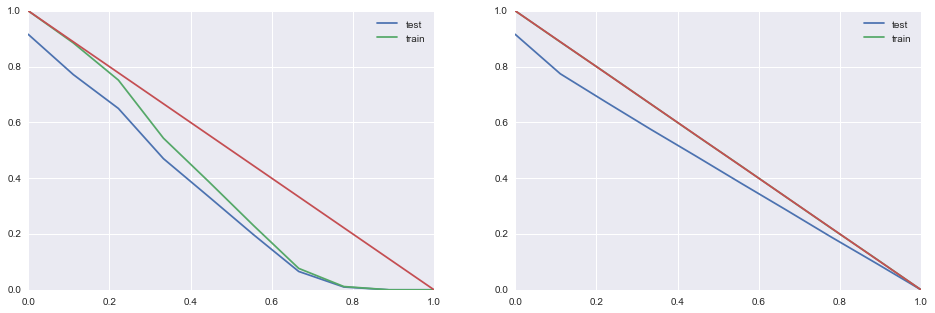

In [15]:
plt.figure(figsize=(16, 5))
p = 10
plt.subplot(1, 2, 1)
h1, = plt.plot(np.linspace(0., 1, p), 
         np.array([np.mean(estimator._f(X, nu) - estimator._r(nu) >= 0) for nu in np.linspace(0., 1, p)]))
h2, = plt.plot(np.linspace(0., 1, p), 
         np.array([np.mean(estimator._f(Xi, nu) - estimator._r(nu) >= 0) for nu in np.linspace(0., 1, p)]))
# plt.plot(np.linspace(0., 1, p), estimator._f(X, 0))
plt.plot(1 - np.linspace(0., 1, p), np.linspace(0., 1, p))
plt.legend([h1, h2], ['test', 'train'], loc=1)

plt.subplot(1, 2, 2)
h3, = plt.plot(np.linspace(0., 1, p), 
         np.array([np.mean(estimator.decision_function(X, nu) >= 0) for nu in np.linspace(0., 1, p)]))
h4, = plt.plot(np.linspace(0., 1, p), 
         np.array([np.mean(estimator.decision_function(Xi, nu) >= 0) for nu in np.linspace(0., 1, p)]))
plt.plot(1 - np.linspace(0., 1, p), np.linspace(0., 1, p))
plt.legend([h3, h4], ['test', 'train'], loc=1)

T fit Empirical Covariance: 0.45711493492126465
T fit Empirical Covariance: 0.3846120834350586
T fit OCSVM: 0.012818098068237305
T fit OCSVM: 0.003837108612060547
T fit Robust Covariance (Minimum Covariance Determinant): 0.5680420398712158
T fit Robust Covariance (Minimum Covariance Determinant): 0.5602929592132568
T fit O2CSVM: 79.34657883644104
T fit O2CSVM: 40.117636919021606


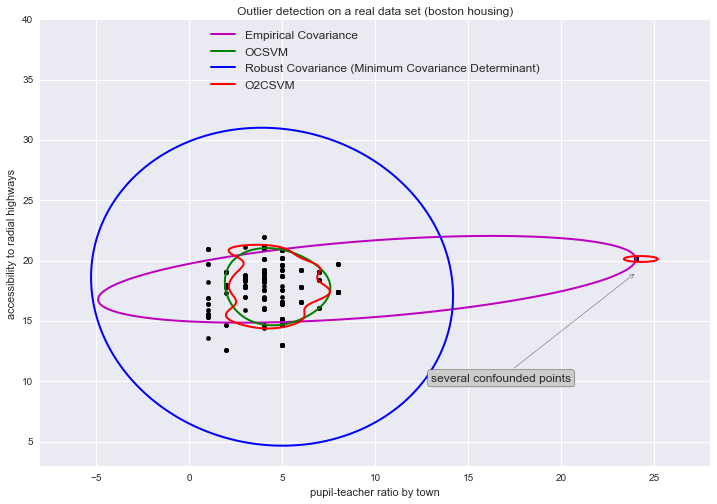

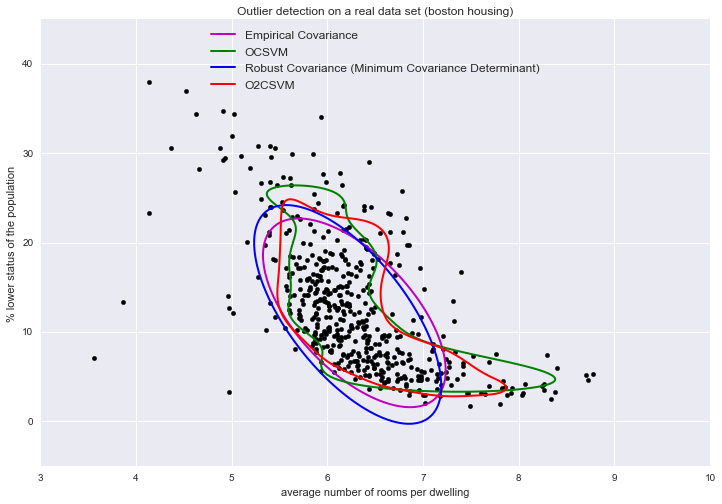

In [6]:
# Author: Virgile Fritsch <virgile.fritsch@inria.fr>
# License: BSD 3 clause

import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston
import time

# Get data
X1 = load_boston()['data'][:, [8, 10]]  # two clusters
X2 = load_boston()['data'][:, [5, 12]]  # "banana"-shaped

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05),
    # gamma =1 for 1st exp
    "O2CSVM": OCCSVM(gamma=3., skewness=.75, nu=0.261)}
colors = ['m', 'g', 'b', 'r']
legend1 = {}
legend2 = {}

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
#     if clf_name is "O2CSVM":
#         clf.gamma = 2.5
#         clf.nu = 0.01
    plt.figure(1, figsize=(12, 8))
    start = time.time()
    clf.fit(X1)
    print ('T fit ' + clf_name + ':', time.time() - start)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    
#     if clf_name is "O2CSVM":
#         clf.gamma = 12.5
#         clf.nu=0.261
    plt.figure(2, figsize=(12, 8))
    start = time.time()
    clf.fit(X2)
    print ('T fit ' + clf_name + ':', time.time() - start)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    print
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list( legend1.values() )
legend1_keys_list = list( legend1.keys() )

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(12, 8))  # two clusters
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0],
            legend1_values_list[3].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2], legend1_keys_list[3]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list( legend2.values() )
legend2_keys_list = list( legend2.keys() )

plt.figure(2, figsize=(12, 8))  # "banana" shape
plt.title("Outlier detection on a real data set (boston housing)")
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0],
            legend2_values_list[3].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2], legend2_keys_list[3]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

plt.show()

/Users/Romain/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Romain/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


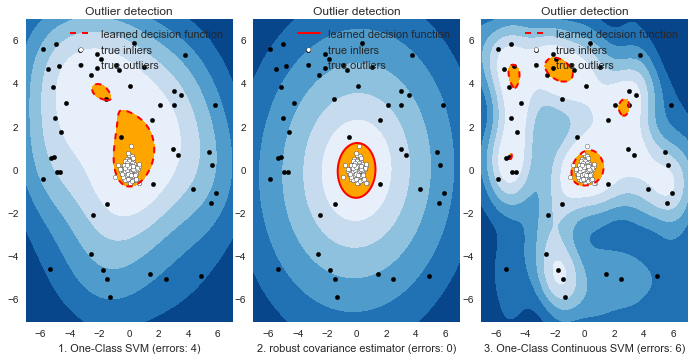

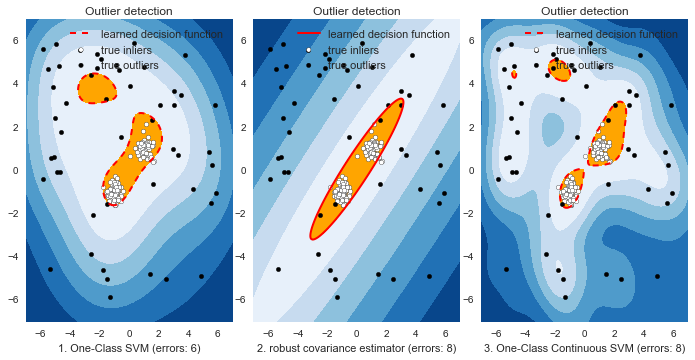

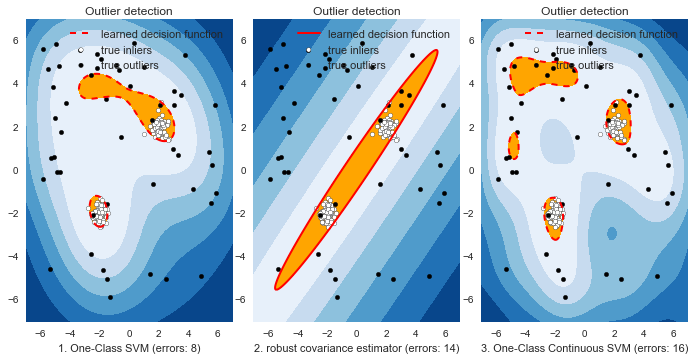

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "robust covariance estimator": EllipticEnvelope(contamination=.1),
    "One-Class Continuous SVM": OCCSVM(nu=0.95 * outliers_fraction + 0.05, gamma=1.25, skewness=.5)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = 0

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(0.5 * n_inliers, 2) - offset
    X2 = 0.3 * np.random.randn(0.5 * n_inliers, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model with the One-Class SVM
    plt.figure(figsize=(10, 5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        y_pred = clf.decision_function(X).ravel()
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * outliers_fraction)
        y_pred = y_pred > threshold
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.set_title("Outlier detection")
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11))
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)

plt.show()

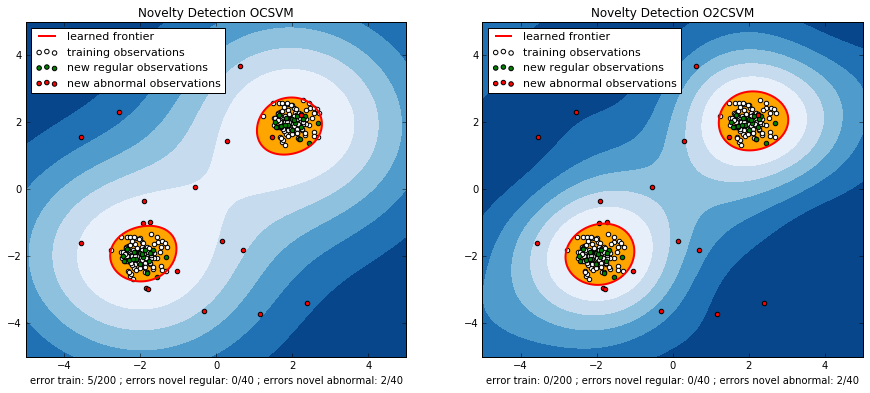

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

np.random.seed(0)
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Novelty Detection OCSVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))


# fit the model
clf = OCCSVM(nu=0.001, gamma=1., D1=500)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.subplot(1, 2, 2)
plt.title("Novelty Detection O2CSVM")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

Continuous one class svm.
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassContinuousSVM ... (81, 14)
done.
 - plot coastlines from coverage
 - predict species distribution
(699800, 14)

 Area under the ROC curve : 0.854240
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassContinuousSVM ... (61, 14)
done.
 - plot coastlines from coverage
 - predict species distribution
(699800, 14)

 Area under the ROC curve : 0.993022

time elapsed: 318.75s


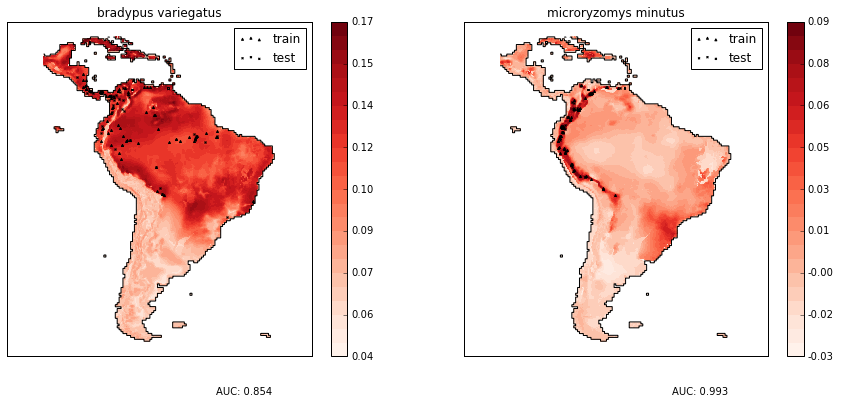

In [19]:
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    plt.figure(figsize=(15, 6))
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassContinuousSVM ... ", end='')
        clf = OCCSVM(gamma=.1, D2=10, s=10, skewness=.1, nu=0)
#         clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        print(train_cover_std.shape)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        print(((coverages_land - mean) / std).shape)
        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

Continuous one class svm.
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.868380
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 6.93s


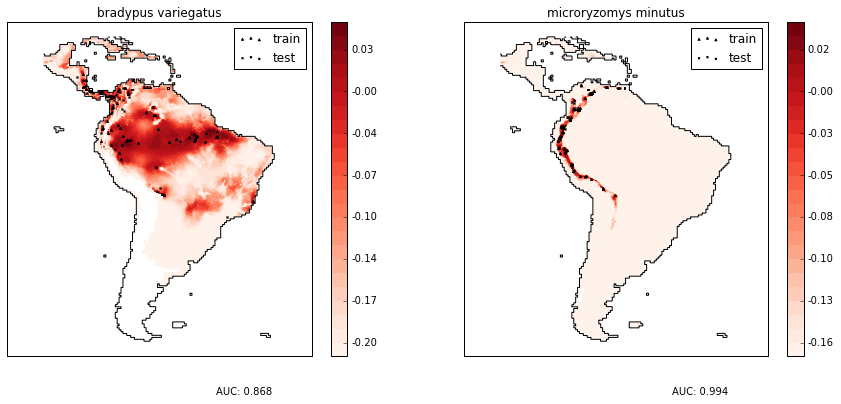

In [13]:
from __future__ import print_function

from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets.base import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    plt.figure(figsize=(15, 6))
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9999], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)[:, 0]
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean)
                                          / std)[:, 0]
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

In [37]:
from sklearn.metrics import roc_curve

In [10]:
fetch_species_distributions?

In [9]:
from sklearn.datasets import fetch_species_distributions
